## Searching for GWs using a PTA
This notebook explores at how to search for GWs using a PTA and an Unscented Kalman filter.


It is entirely concerned with the problem of **detection** (_"Is there evidence of a GW in my data?"_) rather than **parameter estimation** (_"What is the frequency of the GW?"_)


---

## 0. Setup

First lets quickly setup the notebook and make the source code accessible

In [19]:
%load_ext autoreload
%autoreload 2

import sys
# Hacky way to add higher directory to python modules path.
# Means that I dont have to make src/ a proper python package
try:
    sys.path.remove("../src")  
except:
    pass
sys.path.append("../src") 


import pandas as pd 
import seaborn as sns
import numpy as np


sns.set_context("notebook")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## 1. Defining our PTA


In this notebook we will use the 47 pulsars that currently make up the NANOGrav PTA. Getting the data for these pulsars is done separately in `Create-NANOGrav-Pulsars.ipynb`, querying the [ANTF pulsar catalogue](https://www.atnf.csiro.au/research/pulsar/psrcat/).


Recall that the pulsar spindown can generally be expressed as 

$$ \dot{f} \propto f ^n$$

for braking index $n$. 

ANTF provides values for both $f$ and $\dot{f}$. For every pulsar we assume $n=3$ (spindown is solely the result of magnetic dipole radiation), and calculate the constant of proportionality which we label $\gamma$.


For example, PSR J1713+0747 has a spin frequency of 218 Hz and a derivative $-4 \times 10^{-16}$ s $^{-2}$. Taking $n=3$ gives $\gamma \sim 3.9 \times 10^{-23}$. Both $n$ and $\gamma$ will be relevant later when we model the (noisy) pulsar frequency evolution.


The complete dataset of NANOGrav pulsars is stored in `data/NANOGrav_pulsars`.

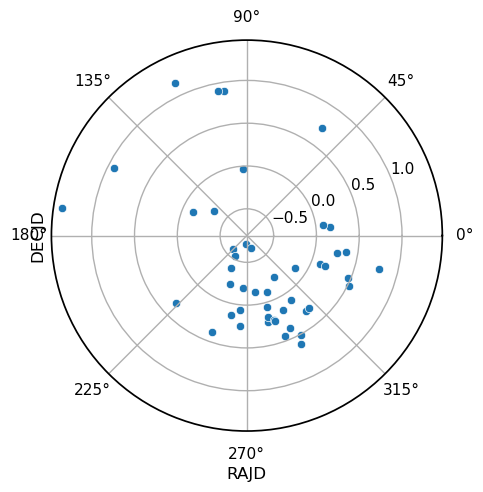

In [17]:
df_PTA = pd.read_pickle('../data/NANOGrav_pulsars')
g = sns.FacetGrid(df_PTA, subplot_kws=dict(projection='polar'),height=5, sharex=False, sharey=False, despine=False)
g.map_dataframe(sns.scatterplot, x='RAJD', y='DECJD')

---


## 2. Creating synthetic data

We have our PTA, we now need to generate some data. Here "data" refers to the frequency timeseries of each pulsar $f(t)$ measured by an observer on Earth, which has been modulated by some distant GW. 

All the pulsar parameters have already been set. For this notebook we take the following parameters for the GW:

* $\omega$ = $1\times 10^{-8}$ (angular frequency of the wave)
* $\Phi_0$ = 0.20 (phase shift)
* $\psi$ = 2.5 (polarisation angle)
* $\iota$ = 0 (source inclination angle)
* RA = 1
* DEC = 0


We leave the GW strain amplitude $h$ as a free parameter that we will vary.

We will make observations over 10 years at a weekly cadence.


All parameters for this notebook are specified in `config.py : notebook`




### 2.1 How the data is generated 


The synthetic data is generated using a similar framework to the state-space structure from Melatos 2022 (private communication to UniMelb EE/GW group), with some small changes.


Firstly we evolve the intrinsic pulsar frequencies $f_p$ and the GW phase $\phi$ by solving the ODEs


$$ \dot{\phi} = \omega$$

$$ \dot{f}_p = -\gamma f_p^n + \xi$$

where  $\xi$ is some stochastic white noise. 


Given the evolution of the state variables, the measured frequencies are


$$ f_m(t) = f_p(t)(1-g(\phi(t))) + N_f$$

for some function $g(\phi)$ which is specified on PT16 of Melatos 2022 and is implicitly a function of the GW parameters listed above. $N_f$ is the Gaussian measurement noise 

### 2.2 Noise magnitudes

Choosing the magnitudes of the process and measurement noises is currently quite uncertain.

For reference note that for PSR J1713+0747:

* $\delta f_m$ due to spindown is $\sim \dot{f} \cdot 10 \text{ years} \sim 30$ nHz 

* $\delta f_m$ due to GW is $\sim f \cdot h \sim 2 \times 10^{-5}$ nHz if $|h| \sim 10^{-16}$



We take the process noise to be $\sigma_p \sim 10^{-12}$ and the measurement noise to be $\sigma_m \sim 10^{-9}$. The choice of these parameters seems reasonable, but requires some more thought.




### 2.3 Generate the data


The mean pulsar frequency over 47 pulsars is 267.2745629611561
The magnitude of the GW strain using these parameters is: 1e-16
The Number format of the observations is: float128
The change in frequency was: 4.9332176443872555183e-07


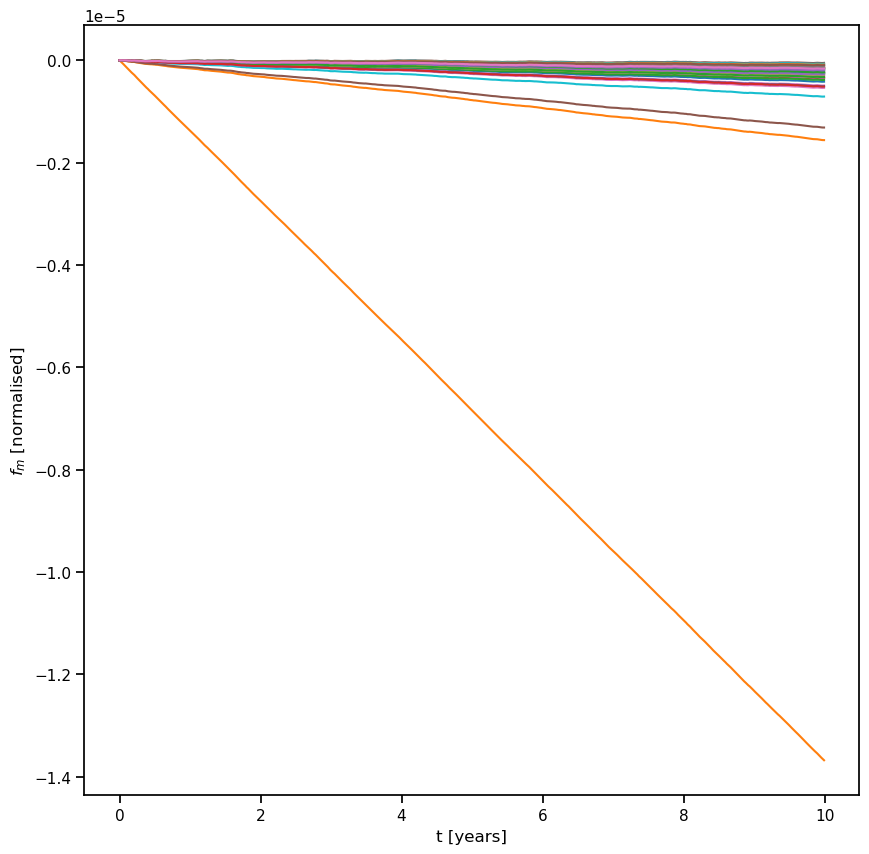

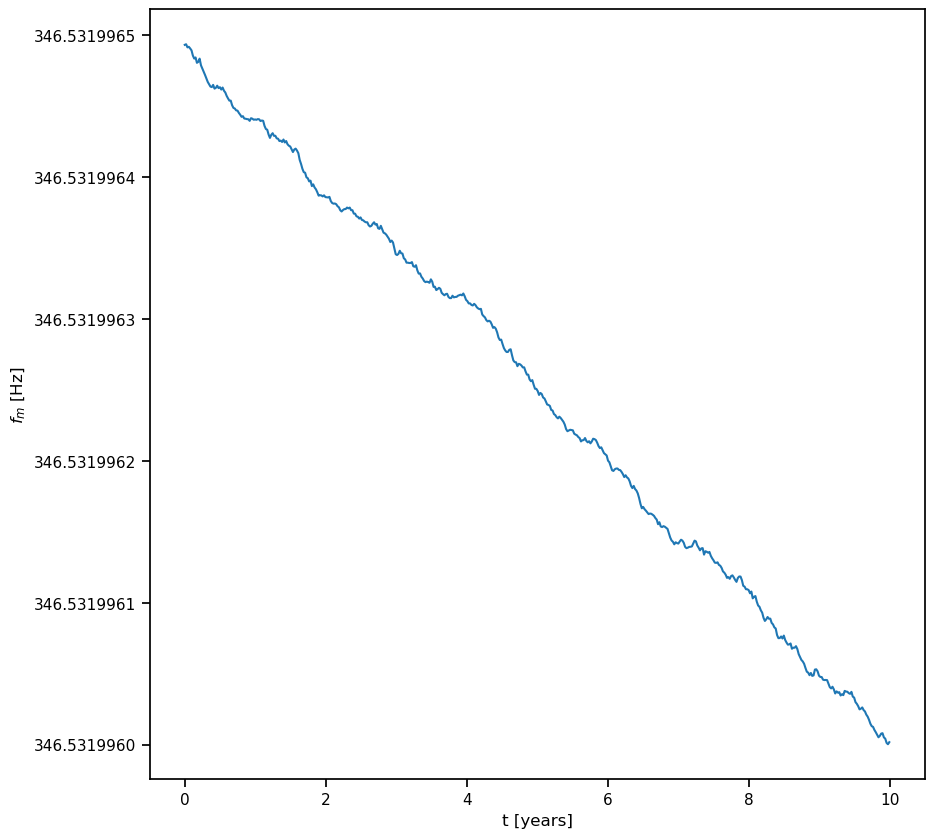

In [141]:
from configs.config import notebook as cfg
from configs.config import NF
from create_synthetic_data import PulsarFrequencyObservations


#First, let's create some synthetic data.
dt   = cfg["timing_parameters"]["dt_days"] 
Tend = cfg["timing_parameters"]["T_years"]     
t    = np.arange(0.0,Tend*365*24*3600,dt*24*3600,dtype=NF) #time runs from 0 to Tend, with intervals dt 

observations = PulsarFrequencyObservations(t,seed_noise=None)              # initialise the class, all observations have same times
observations.create_observations(cfg["pulsar_parameters"],
                                 cfg["GW_parameters"],
                                 cfg["noise_parameters"]) 


observations.plot_measurement_frequency(psr_index=None) #Plot all the pulsars
observations.plot_measurement_frequency(psr_index=6)    #Plot a single pulsar 


The pulsar with the large change in frequency is drop off is J1939+2134 (index 31)	which has an $\dot{f} \sim 10^{-14}$.




Since the GW strain is small, it is not obvious to the eye the effect of the GW on the frequency. IF we crank up the strain:

The mean pulsar frequency over 47 pulsars is 267.2745629611561
The magnitude of the GW strain using these parameters is: 1e-08
The Number format of the observations is: float128
The change in frequency was: 5.9000268390341226166e-07


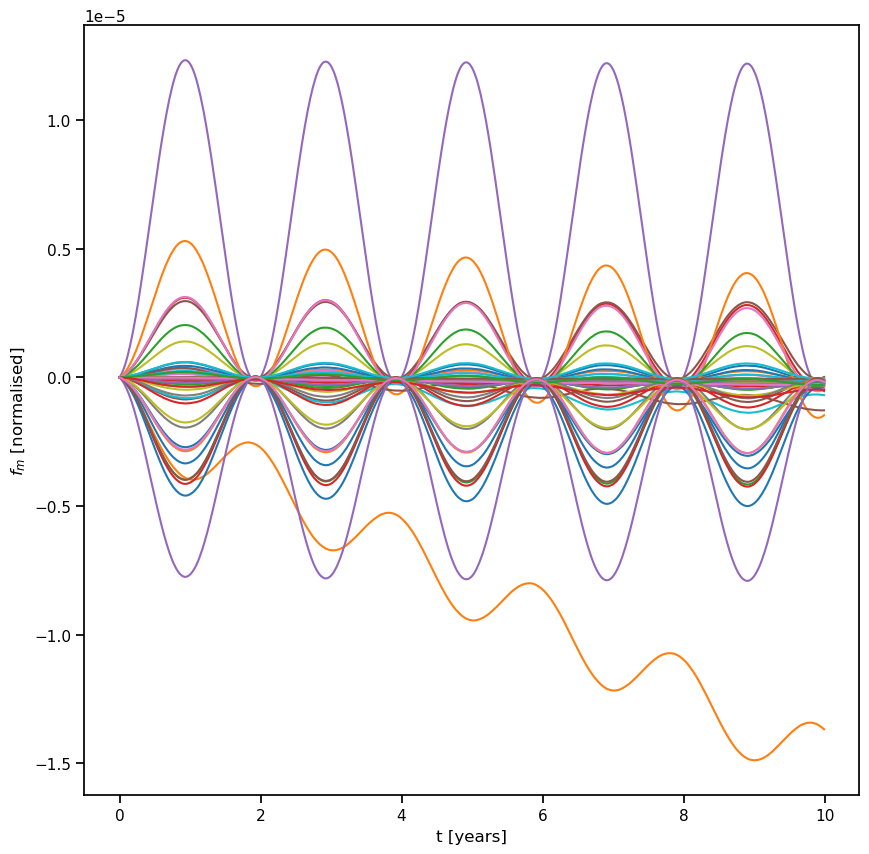

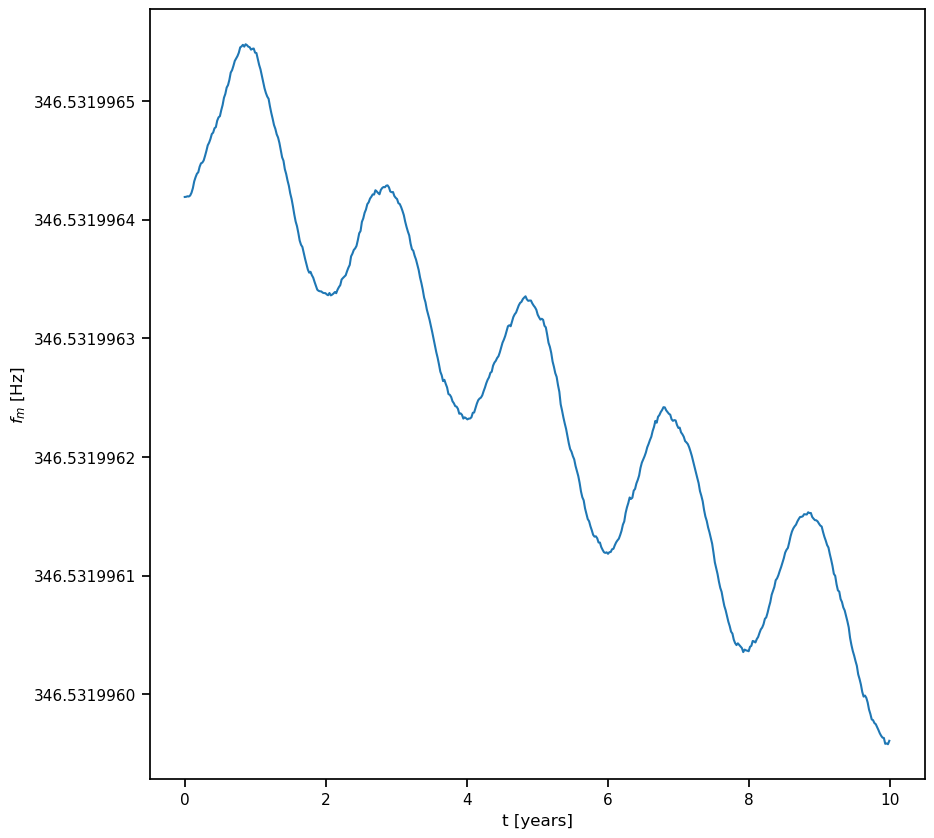

In [143]:
high_strain_observations = PulsarFrequencyObservations(t,seed_noise=None)              # re-initialise the class, 

GW_parameters =  cfg["GW_parameters"]
GW_parameters["h0"] = 1e-8       # override the strain
GW_parameters["omega_GW"] = 1e-7 # and the frequency

high_strain_observations.create_observations(cfg["pulsar_parameters"],
                                             GW_parameters,
                                             cfg["noise_parameters"]) 


high_strain_observations.plot_measurement_frequency(psr_index=None) #Plot all the pulsars
high_strain_observations.plot_measurement_frequency(psr_index=6)    #Plot a single pulsar 

---


## 3. Model selection using a UKF
Given the synthetic data we can now try to use our UKF to try to find evidence of the GW signal in this data.

We have two models:


1. **Null model** $M_0$. There is no GW in the data. In this case the measurement model of the UKF simply returns the frequency states (i.e. $g(\phi) = 0$)

2. **Alternative model** $M_1$. There _is_ a GW in the data. The measurement model uses the full expression for $g(\phi)$



In order to accept the alternative hypothesis $M_1$ over $M_0$ there are two approaches we could take:


* The first is a fully Bayesian search over all the parameters for each model, calculating the evidence for each model and then determining the Bayes ratio. This is perhaps the most consistent way, but it is obviously expensive and at this stage we are keen to explore how detectability varies with e.g. GW strain.

* The second method is to recognize that $M_0$ and $M_1$ are hierarchically nested models and we can perform a likelihood ratio test. That is, given the maximum likelihood estimators $\hat{\theta}$ of the true parameters $\theta$, the likelihood of each model can be calculated and compared. These likelihoods are just  point estimates of the Bayes factor numerator/denominators.


Given the cheap cost we proceed with the second method.


## 3.1 Likelihood ratio test


For the likelihood ratio test we do not perform any kind of maximum likelihood search over the parameters for each of the models. Instead we just set the $\hat{\theta} = \theta$ i.e. artificially set the maximum likelihood estimators to be equal to the true parameters of the system. We assume that any ML algorithm would converge to these parameters - this could be an oversimplification but it serves our purposes for now.


Interpreting the likelihood ratio also needs some consideration, since we have to account for the increased model complexity of $M_1$ (not needed for Bayes factors!). This can be accomplished via [Wilks' Theorem](https://en.wikipedia.org/wiki/Wilks%27_theorem) which states that (for a [large number of samples](https://www.osti.gov/servlets/purl/1529145)) the distribution of the test statistic approaches the chi-squared distribution under the null hypothesis i.e. 

$$ 2 \log \Lambda \rightarrow \chi^2$$




One can then compute $p$-values where the number of degrees of freedom is equal to the difference in the number of parameters of the two models.  $M_1$ has 7 extra parameters over $M_0$.

In [82]:
from scipy.stats.distributions import chi2
chi2.sf(14,7)  #chi2.sf(statistic,dof)

0.051181353413065414

Therefore $D = -2 \log \lambda = 14$ corresponds to a 5% chance that the result occurred under the null hypothesis.

Now lets see how this works in practice:

In [144]:
from UKF import UnscentedKalmanFilter
from model import MelatosPTAModel

    
    
  

#Initialise the state-space model to be used with the UKF
#We pass the model class a dictionary of known quantities that any parameter estimation algo would NOT search over
dictionary_of_known_quantities = {"pulsar_directions": observations.q,                              # we know the pulsar directions
                                  "pulsar_distances":  observations.pulsar_distances,               # for now lets say we also know their distances. In reality we have some constrained prior
                                  "measurement_noise": cfg["noise_parameters"]["measurement_noise"], # and we know the measurement noise of our detector?
                                }
model = MelatosPTAModel(observations.Npulsars + 1,
                        observations.Npulsars,
                        dictionary_of_known_quantities)



#Now initialise the UKF
KF = UnscentedKalmanFilter(
                        observations=observations,
                        model = model,
                        UKF_settings=cfg["UKF_parameters"]
                        )

# Then run it for a particular set of parameters.
# We provide here the actual parameters used to generate the synthetic data
#...under the assumption that any ML algo would find similar values
parameters = {"omega":   observations.omega_GW,
            "gamma":     observations.spindown_gamma[0],
            "n":         observations.spindown_n[0],
            "dec_gw":    cfg["GW_parameters"]["dec_GW"],
            "ra_gw":     cfg["GW_parameters"]["ra_GW"],
            "psi_gw":    cfg["GW_parameters"]["psi_GW"],
            "Agw":       observations.Agw,
            "iota_gw":   cfg["GW_parameters"]["iota"],
            "phi0":      cfg["GW_parameters"]["phase_normalisation"]
            }


#This is the likelihood of the alternative hypothesis
model_likelihood = KF.ll_on_data(parameters,"alternative")

#This is the likelihood of the null hypothesis
null_likelihood = KF.ll_on_data(parameters,"null")

#and the test statistic
test_statistic = 2 * (model_likelihood - null_likelihood)




print(f"Test_statistic is {test_statistic} compared to a target of 14 at a 5% tolerance")


Test_statistic is 136.70454716985574 compared to a target of 14 at a 5% tolerance


Great! So for this particular system (and this particular instance of the noise) we can say that $M_1$ is preferred and there is evidence for a GW in our data.



---


## 4. How does the SNR vary with the system parameters?


The test statistic above is just for one particular system realisation. It is of interest to see how this varies with different system parameters. Lets first package up all the above steps into a single function:


In [145]:
from UKF import UnscentedKalmanFilter
from model import MelatosPTAModel
from configs.config import notebook as cfg
from configs.config import NF
from create_synthetic_data import PulsarFrequencyObservations


import sys



def run(overriding_parameters,seed_noise):



    #First, let's create some synthetic data.
    dt   = cfg["timing_parameters"]["dt_days"] 
    Tend = cfg["timing_parameters"]["T_years"]     
    t    = np.arange(0.0,Tend*365*24*3600,dt*24*3600,dtype=NF) #time runs from 0 to Tend, with intervals dt 


    pulsar_parameters = cfg["pulsar_parameters"]
    GW_parameters     = cfg["GW_parameters"]
    noise_parameters  = cfg["noise_parameters"]


    #Bit verbose - not very Pythonic
    for d in [pulsar_parameters,GW_parameters,noise_parameters]:
        k = d.keys()
        for x in overriding_parameters:
            if x in k:         
                d[x] = NF(overriding_parameters[x]) #override the value in the cfg
                print("Overriding default parameters:", x,overriding_parameters[x])



    observations = PulsarFrequencyObservations(t,seed_noise=seed_noise)              # NOTE THAT WE ARE NOW SEEDING THE NOISE SO IT IS THE SAME FOR ALL ITERATIONS
    observations.create_observations(pulsar_parameters,
                                     GW_parameters,
                                     noise_parameters) 

    

    #Initialise the state-space model to be used with the UKF
    #We pass the model class a dictionary of known quantities that any parameter estimation algo would NOT search over
    dictionary_of_known_quantities = {"pulsar_directions": observations.q,                              # we know the pulsar directions
                                      "pulsar_distances":  observations.pulsar_distances,               # for now lets say we also know their distances. In reality we have some constrained prior
                                      "measurement_noise": noise_parameters["measurement_noise"],       # and we know the measurement noise of our detector?
                                    }
    model = MelatosPTAModel(observations.Npulsars + 1,
                            observations.Npulsars,
                            dictionary_of_known_quantities)



    #Now initialise the UKF
    KF = UnscentedKalmanFilter(
                            observations=observations,
                            model = model,
                            UKF_settings=cfg["UKF_parameters"]
                            )

    # Then run it for a particular set of parameters.
    # We provide here the actual parameters used to generate the synthetic data
    #...under the assumption that any ML algo would find similar values
    parameters = {"omega":   observations.omega_GW,
                "gamma":     observations.spindown_gamma[0],
                "n":         observations.spindown_n[0],
                "dec_gw":    GW_parameters["dec_GW"],
                "ra_gw":     GW_parameters["ra_GW"],
                "psi_gw":    GW_parameters["psi_GW"],
                "Agw":       observations.Agw,
                "iota_gw":   GW_parameters["iota"],
                "phi0":      GW_parameters["phase_normalisation"]
                }


    #This is the likelihood of the alternative hypothesis
    model_likelihood = KF.ll_on_data(parameters,"alternative")

    #This is the likelihood of the null hypothesis
    null_likelihood = KF.ll_on_data(parameters,"null")

    #and the test statistic
    test_statistic = 2 * (model_likelihood - null_likelihood)




    print(f"Test_statistic is {test_statistic} compared to a target of 14 at a 5% tolerance")
    print('-------------------------------------------------------------------------')
    print('-------------------------------------------------------------------------')
    print('-------------------------------------------------------------------------')


    return test_statistic











    

In [152]:
override_parameters = {"h0": NF(1e-16)}
TS = run(override_parameters,seed_noise=2)
print(TS)

Overriding default parameters: h0 9.999999999999999791e-17
The mean pulsar frequency over 47 pulsars is 267.2745629611561
The magnitude of the GW strain using these parameters is: 1e-16
The Number format of the observations is: float128
Test_statistic is 52.19077818094456 compared to a target of 14 at a 5% tolerance
-------------------------------------------------------------------------
-------------------------------------------------------------------------
-------------------------------------------------------------------------
52.190778180944562337


In [139]:
if !isinstance('noseed',int) 

False

In [131]:


Niterations = 3
parameter_space = np.zeros(Niterations)
i = 0
for h in np.linspace(1e-18,1e-15,Niterations):
        override_parameters = {"h0": h, }
        TS = run(override_parameters)
        parameter_space[i] = TS
        i += 1


Overriding default parameters: h0 1e-18
The mean pulsar frequency over 47 pulsars is 267.2745629611561
The magnitude of the GW strain using these parameters is: 1e-18
The Number format of the observations is: float128
Test_statistic is 0.00014673171790491324 compared to a target of 14 at a 5% tolerance
-------------------------------------------------------------------------
-------------------------------------------------------------------------
-------------------------------------------------------------------------
Overriding default parameters: h0 5.005e-16
The mean pulsar frequency over 47 pulsars is 267.2745629611561
The magnitude of the GW strain using these parameters is: 5.005e-16
The Number format of the observations is: float128
Test_statistic is 109.9746633656531 compared to a target of 14 at a 5% tolerance
-------------------------------------------------------------------------
-------------------------------------------------------------------------
-------------------

---

# Appendix

## A1. Caveats 

(I'm sure there are more than listed here...)


* We have asssumed that all pulsars have $n=3$. What about some distribution?

* We have only considered a single GW source at a particualr location, polarisation, etc. What about others?

* We have focused only on a monochromatic GW source. This is probably not a bad approximation, but maybe we can include some process noise on the phase evolution too?

* We assume all pulsars have observations taken at the same time

* How reasonable are our noises? For instance, what is a reasonable measurement noise on the frequency evolution of a MSP?

* What about doing a full Bayesian search using e.g. Bilby to get a Bayes ratio?

* How good/bad an assumption is it that $\hat{\theta} \sim \theta$ for our likelihood ratio test?

In [153]:
data1 = np.load("../src/noise1.npy")
data2 = np.load("../src/noise2.npy")

print(data2-data1)

[[-2.37275608e-12  1.50095550e-12 -1.26328202e-12 ... -9.03795984e-13
  -1.69510593e-12  4.61748832e-15]
 [ 2.09541703e-12 -1.21929527e-12 -1.68645553e-12 ... -1.09052664e-13
   3.63196366e-12  4.37391667e-13]
 [ 1.28220682e-12 -6.25384112e-13  4.55832312e-13 ...  2.78839730e-14
  -3.09871008e-12 -2.35542454e-13]
 ...
 [ 1.49220158e-12 -4.38537092e-13  1.63010222e-12 ...  7.74052950e-13
   2.75435789e-12  1.07175516e-13]
 [-1.21473934e-12 -1.83055059e-12  2.05812309e-13 ... -2.55481423e-13
  -9.14039382e-14  1.74697171e-12]
 [ 1.79095315e-12  6.41051587e-13 -8.58917382e-14 ...  2.82765097e-13
   8.06129858e-13 -1.22365110e-12]]


In [154]:
data1 = np.load("../src/noise3.npy")
data2 = np.load("../src/noise4.npy")

print(data2-data1)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [156]:
data1 = np.load("../src/obs3.npy")
data2 = np.load("../src/obs4.npy")

print(data2-data1)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.81790866e-09 3.81790864e-09 3.81790866e-09 ... 3.81790864e-09
  3.81790866e-09 3.81790864e-09]
 [4.40087231e-09 4.40087228e-09 4.40087231e-09 ... 4.40087228e-09
  4.40087231e-09 4.40087228e-09]
 ...
 [1.00977918e-07 1.00977918e-07 1.00977918e-07 ... 1.00977918e-07
  1.00977918e-07 1.00977915e-07]
 [1.00203156e-07 1.00203156e-07 1.00203156e-07 ... 1.00203156e-07
  1.00203156e-07 1.00203153e-07]
 [9.76463464e-08 9.76463465e-08 9.76463466e-08 ... 9.76463465e-08
  9.76463466e-08 9.76463437e-08]]


In [157]:
data1 = np.load("../src/obs5.npy")
data2 = np.load("../src/obs6.npy")
print(data2-data1)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.61786320e-09 -2.61786319e-09 -2.61786320e-09 ... -2.61786319e-09
  -2.61786320e-09 -2.61786319e-09]
 [-2.46290349e-09 -2.46290351e-09 -2.46290349e-09 ... -2.46290351e-09
  -2.46290349e-09 -2.46290351e-09]
 ...
 [-7.41714656e-08 -7.41714653e-08 -7.41714656e-08 ... -7.41714653e-08
  -7.41714656e-08 -7.41714605e-08]
 [-7.40926853e-08 -7.40926850e-08 -7.40926853e-08 ... -7.40926850e-08
  -7.40926853e-08 -7.40926803e-08]
 [-7.32018990e-08 -7.32018988e-08 -7.32018990e-08 ... -7.32018988e-08
  -7.32018990e-08 -7.32018941e-08]]


In [159]:
data1 = np.load("../src/state31.npy")
data2 = np.load("../src/state32.npy")
print(data2-data1)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.43548293e-10 2.43548307e-10 2.43548293e-10 ... 2.43548307e-10
  2.43548293e-10 2.43548307e-10]
 [1.03927691e-09 1.03927691e-09 1.03927691e-09 ... 1.03927691e-09
  1.03927691e-09 1.03927691e-09]
 ...
 [2.75890177e-08 2.75890176e-08 2.75890177e-08 ... 2.75890176e-08
  2.75890177e-08 2.75890168e-08]
 [2.90376477e-08 2.90376476e-08 2.90376477e-08 ... 2.90376476e-08
  2.90376477e-08 2.90376468e-08]
 [2.93831224e-08 2.93831224e-08 2.93831224e-08 ... 2.93831224e-08
  2.93831224e-08 2.93831216e-08]]


In [165]:
import numpy as np
import sdeint

np.random.seed(1234)

a = 1.0
b = 0.8
tspan = np.linspace(0.0, 5.0, 10001)
x0 = 0.1

def f(x, t):
    return -(a + x*b**2)*(1 - x**2)

def g(x, t):
    return b*(1 - x**2)


result_1 = sdeint.itoint(f, g, x0, tspan)
result_2 = sdeint.itoint(f, g, x0, tspan)

In [166]:
result_2-result_1

array([[ 0.00000000e+00],
       [ 4.08310043e-04],
       [-1.41278264e-02],
       ...,
       [ 1.37493398e-05],
       [ 1.12953145e-05],
       [ 1.21871459e-05]])